
!pip install scikit-learn==1.1.3 -q
!pip install phik -q


!pip install catboost -q

# Исследование популярного музыкального стримингового сервиса "МиФаСоль"

Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

В нашем распоряжении файл, который подготовили коллеги из отдела работы со звуком, в нем собраны некоторые характеристики музыкальных произведений и их жанры. Наша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.


**ПЛАН РАБОТЫ:**

1. Выгрузка и обзор данных.
2. Подготовка данных.

   - Удаление несущественных признаков
   - Работа с пропусками в категориальных признаках
   - Работа с пропусками и выбросами в количественных признаках
   - Проверка на дубликаты
   - Проверка признаков на мультиколлинеарность
3. Создание пайплана для работы с данными.
4. Проверка моделей.
5. Общий вывод.
   

## Обзор данных


In [1]:
#Импортируем необходимые нам в работе инструменты
import pandas as pd
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, cv, Pool
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from numpy.random import RandomState 
state=RandomState(12345)
from sklearn.metrics import f1_score

In [2]:
#Подгружаем данные 
data_train = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/9 мифасоль/train.csv')
data_test = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/9 мифасоль/test.csv')


In [3]:
data_train.head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,4919,By Your Side,33.0,0.000718,0.501,-1.0,0.935,0.020100,G#,0.0831,-5.566,Minor,0.1570,144.922,4-Apr,0.1880,Electronic
1,16096,NaN,55.0,0.064700,0.282,288333.0,0.738,0.014200,C,0.2900,-5.566,Major,0.0324,126.914,NaN,0.2110,Alternative
2,43825,Symphony No. 6: VI. Allegro,39.0,0.931000,0.364,115240.0,0.349,0.940000,NaN,0.1100,-13.279,NaN,0.0321,65.42699999999999,4-Apr,0.0891,Classical
3,4331,NaN,56.0,0.012300,0.332,234638.0,0.847,0.000027,B,0.2970,-4.513,Minor,0.0910,67.23,5-Apr,0.3920,Electronic
4,21371,Shoe Shopping,52.0,0.580000,0.716,221640.0,0.614,0.000014,G,0.1600,-7.099,Major,0.0360,88.006,4-Apr,0.6800,Country


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40000 non-null  int64  
 1   track_name        29262 non-null  object 
 2   popularity        36078 non-null  float64
 3   acousticness      40000 non-null  float64
 4   danceability      37963 non-null  float64
 5   duration_ms       40000 non-null  float64
 6   energy            40000 non-null  float64
 7   instrumentalness  40000 non-null  float64
 8   key               38577 non-null  object 
 9   liveness          40000 non-null  float64
 10  loudness          40000 non-null  float64
 11  mode              38147 non-null  object 
 12  speechiness       40000 non-null  float64
 13  tempo             40000 non-null  object 
 14  obtained_date     33781 non-null  object 
 15  valence           40000 non-null  float64
 16  music_genre       40000 non-null  object

 train.csv - информация (~40000) музыкальных треках, которые будут использоваться в качестве обучающих данных.

Описание полей данных:

**instance_id** -Уникальный идентификатор трека

**track_name** - Название трека

**acousticness** - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим. 1,0 означает высокую степень уверенности в том, что трек является акустическим

**danceability** - Танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность. Значение 0,0 означает наименьшую танцевальность, а 1,0 - наибольшую танцевальность

**duration_ms** - Продолжительность трека в миллисекундах

**energy** - Энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности. Как правило, энергичные композиции ощущаются как быстрые, громкие и шумные. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха имеет низкую оценку этого параметра

**instrumentalness** - Определяет, содержит ли трек вокал. Звуки "Ooh" и "aah" в данном контексте рассматриваются как инструментальные. Рэп или разговорные треки явно являются "вокальными". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокала

**key** - базовый ключ (нота) произведения

**liveness** - Определяет присутствие аудитории в записи. Более высокие значения liveness означают увеличение вероятности того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек исполняется вживую

**loudness** - Общая громкость трека в децибелах (дБ)

**mode** - Указывает на модальность (мажорную или минорную) трека

**speechiness** - Речевой характер определяет наличие в треке разговорной речи. Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0. Значения выше 0,66 характеризуют треки, которые, вероятно, полностью состоят из разговорной речи. Значения от 0,33 до 0,66 характеризуют треки, которые могут содержать как музыку, так и речь, как в виде фрагментов, так и в виде слоев, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие неречевые треки

**tempo** - Темп трека в ударах в минуту (BPM). В музыкальной терминологии темп представляет собой скорость или темп данного произведения и напрямую зависит от средней продолжительности тактов

**obtained_date** - дата загрузки в сервис

**valence** - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком. Композиции с высокой валентностью звучат более позитивно (например, радостно, весело, эйфорично), а композиции с низкой валентностью - более негативно (например, грустно, депрессивно, сердито)

**music_genre** - Музыкальный жанр трека


In [5]:
data_test.head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,20514,Bullet Proof ... I Wish I Was,49.0,0.7800,0.448,208733.0,0.359,0.671000,G,0.0753,-13.559,Major,0.0288,80.91199999999999,4-Apr,0.0773
1,46957,Does It,48.0,0.2120,0.651,262547.0,0.655,0.000198,A,0.2060,-9.430,NaN,0.1650,120.10799999999999,4-Apr,0.2710
2,5488,NaN,34.0,0.1630,0.595,270733.0,0.277,0.677000,C#,0.1310,-14.141,Major,0.0391,153.464,3-Apr,0.1450
3,18150,Breaking Inside (feat. Lzzy Hale of Halestorm),41.0,0.0684,0.466,227467.0,0.912,0.000000,D,0.0892,-3.423,Minor,0.0474,151.977,4-Apr,0.4160
4,20148,NaN,47.0,0.0012,0.345,298813.0,0.974,0.000030,D,0.3620,-3.221,Minor,0.0607,175.02700000000002,4-Apr,0.5710


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        7388 non-null   object 
 2   popularity        8987 non-null   float64
 3   acousticness      10000 non-null  float64
 4   danceability      9477 non-null   float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9673 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9518 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  object 
 14  obtained_date     8419 non-null   object 
 15  valence           10000 non-null  float64
dtypes: float64(10), int64(1), object(5)
memor

- test.csv - информация (~10000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Наша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.


**Промежуточный вывод**

Данные выгружены успешно. 

40000 объектов в обучающей выборке и 10000 в тестовой.

    После беглого просмотра данных наметим некий план по предобработке данных.

***Задачи***

- Работа с пропусками.
- Рассмотреть данные по дате
- изучить пропуски в категориальных значениях
  - track_name
  - key 
  - mode
- изучить пропуски в количественных значениях
  - popularity
  - danceability 
  - tempo рассмотреть данные. Почему они представлены НЕ в числовом фомате. Исправить на нужные. 
- Проверка на дубликаты  

## 2.Предобработка и исследовательский анализ данных

Рассмотрим данные поподробннее

В наших данных для обучения содержится информация о 4000 треках. Это композиции в 10 жанрах. Данные распределены примерно одинаково.

### Обработка пропусков и аномалий
## 2.1 Obtained date

In [7]:
#Изучаем время
print('Уникальные значения в по дате загрузки в тестовой выборке', data_test['obtained_date'].unique())
print('Уникальные значения в по дате загрузки в тренировочной выборке', data_train['obtained_date'].unique())

Уникальные значения в по дате загрузки в тестовой выборке ['4-Apr' '3-Apr' nan '5-Apr' '1-Apr']
Уникальные значения в по дате загрузки в тренировочной выборке ['4-Apr' nan '5-Apr' '3-Apr' '1-Apr' '0/4']


In [8]:
data_train.query('obtained_date == "0/4"')

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
11319,29297,Imma Be,61.0,0.184,0.619,257560.0,0.539,0.0,C,0.288,-6.9,Major,0.387,?,0/4,0.424,Rap


Большая часть данных была добавлена в течении 4 дней. За исключением одного объекта в тренировочной выборке, скорее всего просто ошибка.) Эти данные не являются ценными.

Удалим этот признак.

In [9]:
#Удаляем признак obtained_date
data_train = data_train.drop('obtained_date', axis=1)
data_test = data_test.drop('obtained_date', axis=1)

### 2.2 track_name

Приведем все названия в единый вид. Все переведем в строчный регистр, уберем артикли и удалим лишние пробелы. Это сократит количество уникальных значений.

In [10]:
print(f"До изменений в имени трэка в train-e  было {data_train['track_name'].nunique()} уникальных значений.")
data_train['track_name'] = data_train['track_name'].str.lower().replace(['the', 'a'], '').str.strip()
print('стало', data_train['track_name'].nunique())
print('_______________________________________')
print()
print(f"В test-e было {data_test['track_name'].nunique()} уникальных значений")
data_test['track_name'] = data_test['track_name'].str.lower().replace('the', '').str.strip()
print('стало', data_test['track_name'].nunique())
      

До изменений в имени трэка в train-e  было 26018 уникальных значений.
стало 25765
_______________________________________

В test-e было 7123 уникальных значений
стало 7094


In [12]:
data_train['track_name'].value_counts()

track_name
home                                                           12
intro                                                           9
fire                                                            9
gravity                                                         8
blue                                                            8
                                                               ..
lady lay down                                                   1
love me or leave me alone (feat. karen fairchild)               1
tall, tall trees                                                1
finger                                                          1
floyd mayweather (feat. travis scott, gucci mane and gunna)     1
Name: count, Length: 25765, dtype: int64

Заменим пропуски на no_name

In [11]:
data_train['track_name'] = data_train['track_name'].fillna('no_name')
data_test['track_name'] = data_test['track_name'].fillna('no_name')

### 2.3 кey

In [12]:
#Смотрим уникальные значения key
print('Уникальные значения key в train-e', data_train['key'].unique())
print('Уникальные значения key в teste-e', data_test['key'].unique())

Уникальные значения key в train-e ['G#' 'C' nan 'B' 'G' 'D' 'E' 'C#' 'A' 'F' 'A#' 'F#' 'D#']
Уникальные значения key в teste-e ['G' 'A' 'C#' 'D' 'F#' 'F' 'A#' 'C' 'B' 'G#' 'E' 'D#' nan]


Здесь все корректно, 7 нот и 5 полутонов.

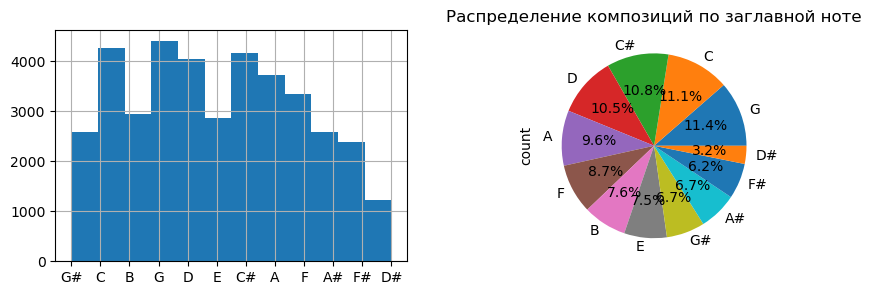

In [13]:

plt.subplot(1, 2, 1)
data_train['key'].hist(bins=12, figsize = (10,3))
plt.subplot(1, 2, 2)
data_train['key'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize = (10,3))
plt.title('Распределение композиций по заглавной ноте')
plt.show()

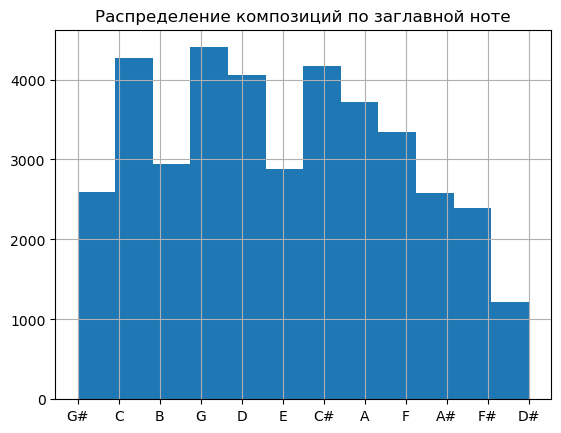

In [14]:
data_train['key'].hist(bins=12)
plt.title('Распределение композиций по заглавной ноте')
plt.show()

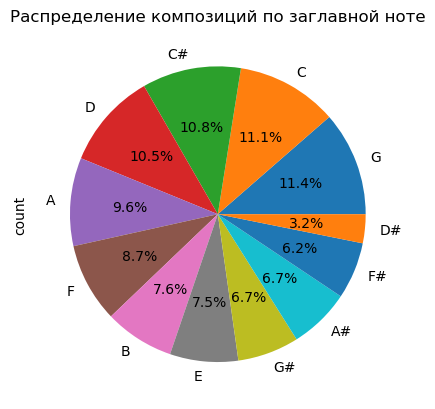

In [15]:
data_train['key'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение композиций по заглавной ноте')
plt.show()

Больше всего треков в тональностях Соль и До. Меньше всего в Ре-Диез.

### 2.4 mode

In [16]:
#Изучаем и причесываем mode в train-е
print(data_train['mode'].unique())
print()
print(data_test['mode'].unique())

['Minor' 'Major' nan]

['Major' nan 'Minor']


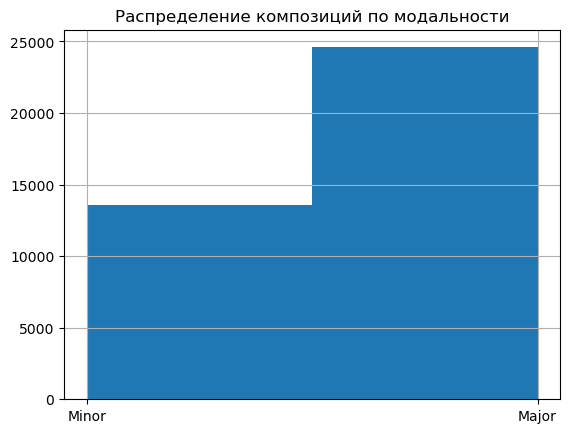

In [17]:
data_train['mode'].hist(bins=2)
plt.title('Распределение композиций по модальности')
plt.show()

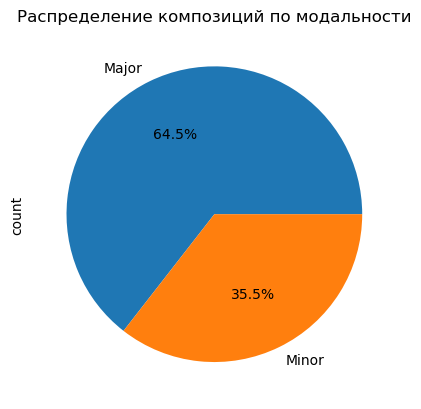

In [18]:
data_train['mode'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение композиций по модальности')
plt.show()

Треков в мажорной тональности почти в 2 раза больше.

### 2.5 music_genre

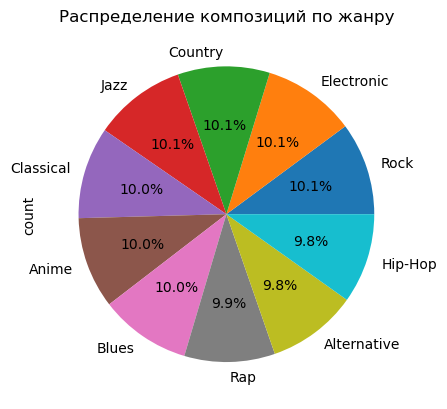

In [19]:
data_train['music_genre'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение композиций по жанру')
plt.show()

В наших данных для обучения содержится информация о 40000 треках. Это композиции в 10 жанрах. Данные распределены примерно одинаково.

### 2.6 danceability

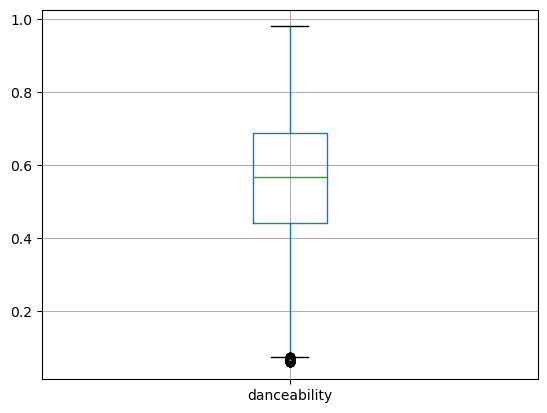

In [20]:
data_train.boxplot(column='danceability')
plt.show()

Есть выбросы. Композиции с танцевальностью меньше 0.1.

Рассмотрим их повнимательнее.

In [21]:
data_train.query('danceability < 0.1').head(50)

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
49,7045,too dreadful a practice for this open air,17.0,0.9110,0.0828,99809.0,0.24600,0.0429,C,0.2050,-13.141,Major,0.0396,80.759,0.1190,Anime
121,1697,"oxygene, pt. 1",41.0,0.7720,0.0822,460640.0,0.29700,0.1860,G,0.2500,-15.023,Minor,0.0398,173.19400000000002,0.0351,Electronic
179,44129,cavalleria rusticana: symphonic intermezzo,29.0,0.6390,0.0800,221453.0,0.05800,0.8620,F,0.4490,-25.828,Major,0.0374,81.848,0.0549,Classical
352,43592,"canon in d, p. 37",26.0,0.6070,0.0946,271413.0,0.17300,0.8800,A,0.1200,-21.688,Major,0.0378,83.304,0.1030,Classical
411,43771,"the road goes ever on... pt. 2 / ""in dreams"" (...",36.0,0.9610,0.0772,221227.0,0.14300,0.7240,A,0.1030,-18.892,Major,0.0423,69.973,0.0385,Classical
489,41598,no_name,26.0,0.9570,0.0755,303067.0,0.01630,0.8980,D,0.0951,-29.119,Major,1.0535,78.566,0.0643,Classical
636,7171,kizuna,NaN,0.7570,0.0882,154373.0,0.30600,0.9220,G,0.1580,-9.226,Minor,0.0328,166.24900000000002,0.0573,Anime
710,45517,"sibelius: violin concerto in d minor, op. 47: ...",29.0,0.9490,0.0957,529387.0,0.13100,0.0839,A#,0.1310,-20.571,Major,0.0438,84.305,0.0358,Classical
886,45244,no_name,30.0,0.9820,0.0630,68600.0,0.05800,0.8430,A,0.0890,-35.570,Major,0.0414,75.047,0.0477,Classical
923,6392,no_name,15.0,0.7770,0.0984,181533.0,0.40600,0.8220,E,0.1980,-10.789,Minor,0.0401,79.718,0.0538,Anime


In [22]:
print('Композиций с танцевальностью меньше 0.1:', len(data_train.loc[((data_train['danceability'] <= 0.1))]))

Композиций с танцевальностью меньше 0.1: 225


Судя по названию, большинство таких композиций это классическая музыка и концерты. В таком случае, это информативная история. От таких выбросов избавляться не будем. 

А вот пропуски заполним медианным значением.

In [23]:
#Заполняем пропуски danceability
for x in [data_train, data_test]:
    x['danceability'] = x['danceability'].fillna(x['danceability'].median())


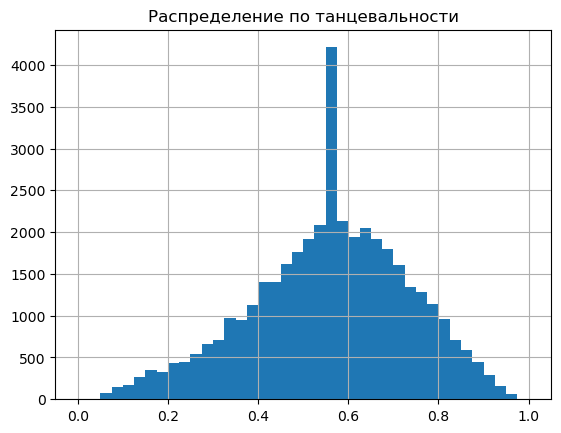

In [24]:
data_train['danceability'].hist(bins=40, range= (0, 1))
plt.title('Распределение по танцевальности')
plt.show()

### 2.7 popularity

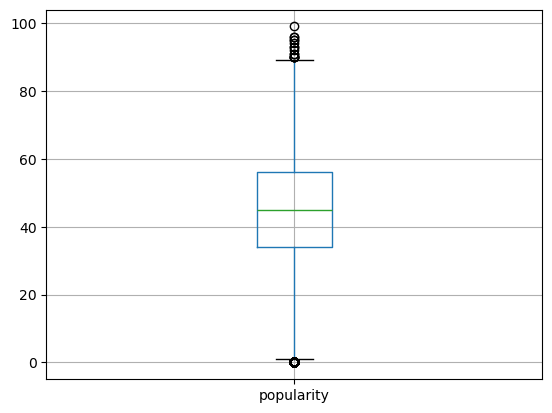

count    36078.000000
mean        44.180969
std         15.550792
min          0.000000
25%         34.000000
50%         45.000000
75%         56.000000
max         99.000000
Name: popularity, dtype: float64

In [25]:
data_train.boxplot(column='popularity')
plt.show()
data_train['popularity'].describe()

Есть выбросы. Треки с популярностью больше 85 и меньше 0. Рассмотрим внимательнее.

In [26]:
data_train.query('popularity > 85').head(50)

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
52,1105,"taki taki (with selena gomez, ozuna & cardi b)",96.0,0.153000,0.841,212500.0,0.798,0.000003,C#,0.0618,-74.206,NaN,0.2290,95.948,0.5910,Electronic
796,47036,splashin,88.0,0.001950,0.942,177806.0,0.383,0.000000,A#,0.0922,-8.099,Major,0.5650,100.021,0.3800,Hip-Hop
1223,50206,everybody dies in their nightmares,86.0,0.847000,0.734,95467.0,0.570,0.000021,G,0.1120,-7.066,Minor,0.1330,129.953,0.6890,Hip-Hop
2826,49244,no_name,95.0,0.259000,0.889,180522.0,0.496,0.000000,E,0.2520,-6.365,Minor,0.0905,86.00299999999999,0.5440,Hip-Hop
4744,39384,natural,89.0,0.217000,0.704,189467.0,0.611,0.000000,D,0.0812,-6.112,Major,0.0409,100.0,0.2200,Rock
6595,28481,splashin,88.0,0.001950,0.942,177806.0,0.383,0.000000,A#,0.0922,-8.099,Major,0.5650,100.021,0.3800,Rap
6878,27745,falling down - bonus track,87.0,0.017500,0.669,196400.0,0.574,0.002940,E,0.1460,-6.442,Minor,0.0286,120.01299999999999,0.2730,Rap
8562,27234,no_name,99.0,0.163000,0.833,149520.0,0.539,0.000002,B,0.1010,-7.399,NaN,0.1780,99.947,0.3850,Rap
8895,48019,middle child,96.0,0.149000,0.837,213594.0,0.364,0.000000,G#,0.2710,-11.713,Major,0.2760,123.984,0.4630,Hip-Hop
9168,26592,pure cocaine,86.0,0.001270,0.964,154024.0,0.487,0.000007,A#,0.1150,-6.071,Minor,0.4210,127.05,0.1070,Rap


Просто популярные Рэп, Рок, Хип-Хоп и электро композиции. Звучит "модно". Похоже на правду, оставляем.

In [27]:
data_train.query('popularity < 10').head(50)

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
38,13234,i want to be - remastered,3.0,0.967000,0.572,116893.0,0.55400,0.000000,A,0.7270,-79.929,Major,0.7080,125.601,0.8350,Jazz
88,44278,"les contes d'hoffmann, act ii: entr'acte - ell...",0.0,0.964000,0.569,-1.0,0.01790,0.000092,A#,0.3540,-27.506,Major,0.0533,173.78,0.0346,Classical
90,43611,"fidelio, op. 72, act i: ihr könnt das leicht s...",0.0,0.754000,0.550,106013.0,0.02370,0.000000,C,0.2440,-38.267,Major,0.1420,?,0.2000,Classical
236,7388,hangeki no yaiba,8.0,0.030500,0.362,217253.0,0.97300,0.016500,B,0.1960,-1.998,Major,0.1670,180.175,0.6580,Anime
252,45267,hochzeitsmarsch (wedding march),0.0,0.956000,0.357,286800.0,0.39700,0.884000,C,0.0647,-9.305,Major,0.0322,79.976,0.2160,Classical
263,43756,no_name,0.0,0.981000,0.355,144987.0,0.06130,0.862000,G#,0.1570,-20.560,Major,0.0323,104.601,0.3310,Classical
266,42482,"norwegian peasant dances, op. 72: xvi. the gir...",0.0,0.994000,0.569,82493.0,0.01810,0.971000,F,0.0719,-35.398,Major,0.0461,136.049,0.1200,Classical
268,6827,light of the evanescence (feat. the tokyo metr...,8.0,0.859000,0.139,152200.0,0.29200,0.879000,A,0.1540,-14.884,Minor,0.0375,?,0.0371,Anime
309,42960,"fidelio, op. 72, act ii: euch werde lohn in be...",0.0,0.960000,0.251,403653.0,0.08310,0.000028,A,0.2020,-25.790,Major,0.0477,86.302,0.1220,Classical
351,45744,the charlatan suite (arr. k. brion for wind ba...,0.0,0.986000,0.194,120467.0,0.02790,0.865000,F,0.1650,-27.730,Major,0.0465,138.506,0.1530,Classical


Классика не в почете.
Чайковский переворачивается в ...

In [28]:
print('Композиция с экстремальными значениями по признакому популярность', len(data_train.loc[((data_train['popularity'] >= 85) | (data_train['popularity' ] <= 10))]))

Композиция с экстремальными значениями по признакому популярность 860


Оставляем все объекты. Пропуски заполняем медианным значением.

In [29]:
for x in [data_train, data_test]:
    x['popularity'] = x['popularity'].fillna(x['popularity'].median())

### 2.8 tempo

Количественный признак, но почему-то записан в формате строки. Выявим аномалию и исправим.

In [30]:
data_train['tempo'].value_counts()

tempo
?                     3979
120.0                   15
100.014                 14
119.985                 13
100.00200000000001      13
                      ... 
70.002                   1
144.458                  1
84.757                   1
158.241                  1
104.436                  1
Name: count, Length: 25110, dtype: int64

In [31]:
data_test['tempo'].value_counts()

tempo
?                     1001
89.992                   5
99.99799999999999        5
100.00299999999999       5
140.007                  5
                      ... 
133.98                   1
113.29899999999999       1
104.98899999999999       1
104.85600000000001       1
101.95299999999999       1
Name: count, Length: 7941, dtype: int64

Такой формат из-за значения '?'. Высчитаем медианное  заменим '?' на него.

In [32]:
for x in [data_train, data_test]:

    data_tempo = x.query('tempo != "?"')
    data_tempo['tempo'] = data_tempo['tempo'].astype('float64')
    med_tempo = data_tempo['tempo'].median()
    x['tempo'] = x['tempo'].replace('?', med_tempo).astype('float64') 

/var/folders/rh/m635vnx9069_1y61mcn7n51h0000gn/T/ipykernel_8189/1165725778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tempo['tempo'] = data_tempo['tempo'].astype('float64')
/var/folders/rh/m635vnx9069_1y61mcn7n51h0000gn/T/ipykernel_8189/1165725778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tempo['tempo'] = data_tempo['tempo'].astype('float64')


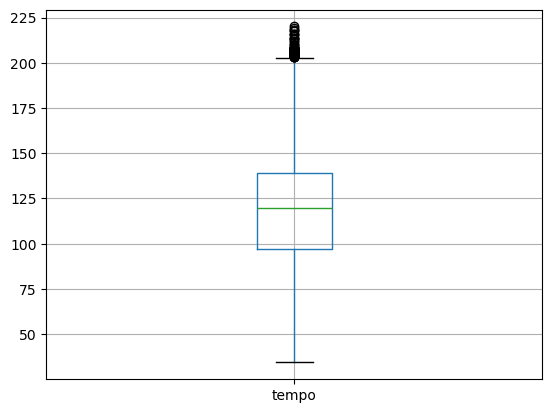

In [33]:
data_train.boxplot(column = 'tempo');

In [34]:
print('Композиций со скоростью тактов больше 190:', len(data_train.loc[((data_train['tempo'] >= 190))]))

Композиций со скоростью тактов больше 190: 399


### 2.9 duration

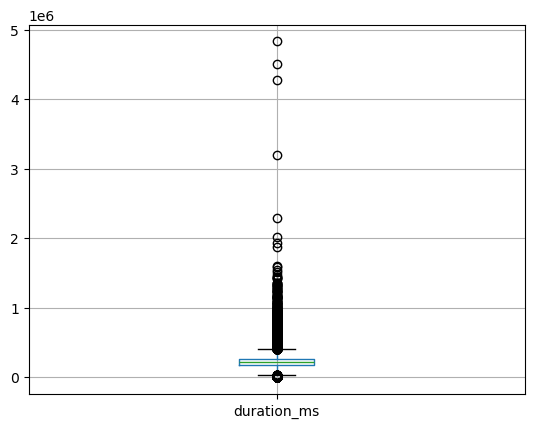

count    4.000000e+04
mean     2.213221e+05
std      1.297367e+05
min     -1.000000e+00
25%      1.748498e+05
50%      2.193200e+05
75%      2.686670e+05
max      4.830606e+06
Name: duration_ms, dtype: float64

In [35]:
data_train.boxplot(column='duration_ms')
plt.show()
data_train['duration_ms'].describe()

In [36]:
data_train['duration_ms'].max()

4830606.0

In [37]:
print('Композиция с аномальными значениями длительности', len(data_train.loc[((data_train['duration_ms'] >= 500000) | (data_train['popularity' ] <= 0))]))

Композиция с аномальными значениями длительности 1333


In [38]:
data_train.query('duration_ms < 0').head(50)

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,4919,by your side,33.0,0.000718,0.501,-1.0,0.9350,0.020100,G#,0.0831,-5.566,Minor,0.1570,144.922,0.1880,Electronic
19,12491,no_name,33.0,0.269000,0.580,-1.0,0.7480,0.866000,C#,0.0777,-7.736,Major,0.0307,97.258,0.7620,Jazz
25,46065,dreams,45.0,0.394000,0.490,-1.0,0.3510,0.000008,B,0.1110,-12.918,Minor,0.1940,82.127,0.3160,Hip-Hop
27,48579,sorry,55.0,0.428000,0.870,-1.0,0.5310,0.000000,F,0.0798,-6.471,Major,0.0992,119.901,0.3150,Hip-Hop
31,19239,dead leaves and the dirty ground,46.0,0.471000,0.363,-1.0,0.6110,0.000003,B,0.0735,-4.215,Minor,0.0330,119.901,0.4600,Alternative
33,26376,figaro,53.0,0.188000,0.836,-1.0,0.8120,0.000002,D,0.0982,-6.985,Major,0.2150,92.009,0.7690,Rap
43,20289,souk eye,55.0,0.430000,0.640,-1.0,0.8530,0.711000,D,0.1560,-7.996,Minor,0.0310,124.122,0.8290,Alternative
46,40617,always,61.0,0.665000,0.408,-1.0,0.4990,0.000000,A,0.1100,-7.651,Major,0.0323,88.968,0.5540,Rock
51,28993,verbatim,61.0,0.057800,0.667,-1.0,0.4930,0.000000,F,0.3670,-11.207,Minor,0.0546,124.128,0.3130,Rap
56,22987,drunk drunk,38.0,0.068300,0.526,-1.0,0.8810,0.000000,F,0.7010,-3.829,Major,0.0590,119.901,0.8730,Country


Тут какая-то ошибка в данных. Не может быть длина трека отрицательной.
Данные обьекты мы удалим.

In [39]:
data_train = data_train.query('duration_ms > 0')

In [40]:
data_train.query('duration_ms > 500000').head(50)

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
201,45547,"keyboard sonata no. 60 in c major, hob.xvi:50:...",28.0,0.989000,0.3080,720627.0,0.1230,0.887000,C,0.0754,-23.975,Major,0.0366,106.649,0.2450,Classical
233,1221,no_name,48.0,0.252000,0.8790,537164.0,0.7770,0.849000,A#,0.0883,-10.709,Minor,0.0559,110.003,0.1980,Electronic
431,41640,"scottish fantasy, op.46: 1. adagio cantabile",27.0,0.906000,0.2040,506091.0,0.1690,0.733000,D#,0.1110,-19.553,Major,0.0432,111.203,0.0400,Classical
446,11289,alice in wonderland - take 2 / live at the vil...,39.0,0.852000,0.4340,514533.0,0.2970,0.861000,C,0.7110,-18.316,Major,0.0347,119.901,0.3640,Jazz
452,50880,mural,45.0,0.011000,0.4310,528880.0,0.8980,0.001150,C#,0.5230,-4.233,Minor,0.1660,119.901,0.1920,Hip-Hop
710,45517,"sibelius: violin concerto in d minor, op. 47: ...",29.0,0.949000,0.0957,529387.0,0.1310,0.083900,A#,0.1310,-20.571,Major,0.0438,84.305,0.0358,Classical
740,32789,sad and deep as you,45.0,0.188000,0.3500,837160.0,0.3190,0.767000,E,0.9590,-79.307,Minor,0.0299,112.871,0.0685,Blues
790,42023,"piano concerto no.4 in g, op.58: 1. allegro mo...",29.0,0.980000,0.3130,1157000.0,0.1170,0.917000,G,0.0445,-21.584,Major,0.0372,119.901,0.0549,Classical
870,45955,"mozart: piano concerto no. 25 in c major, k. 5...",45.0,0.985000,0.3000,540800.0,0.1090,0.907000,C,0.0598,-22.560,Major,1.0344,88.945,0.3890,Classical
885,44187,beethoven : symphony no.9 in d minor op.125 : ...,64.0,0.964000,0.3640,822307.0,0.1890,0.820000,D,0.0769,-22.125,Minor,0.0425,111.408,0.2830,Classical


Опять классика. Похоже на правду. Оставляем.

### 2.10 loudness

<Axes: >

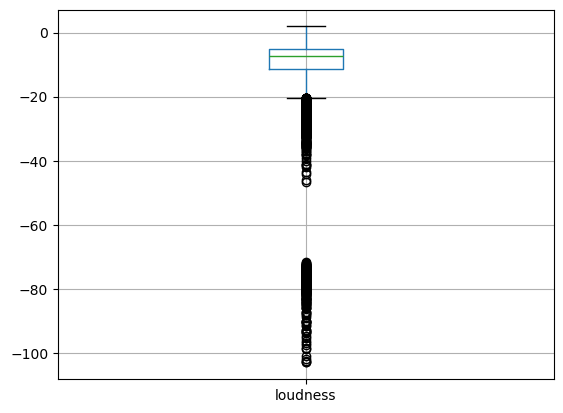

In [41]:
data_tempo.boxplot(column = 'loudness')

In [42]:
print('Композиция с аномальными значениями длительности', len(data_train.loc[((data_train['loudness'] <= -60))]))

Композиция с аномальными значениями длительности 1314


In [43]:
data_train = data_train.query('loudness > -60')

### 2.11 acousticness, energy, instrumentalness, liveness, speechiness, valence

<Axes: >

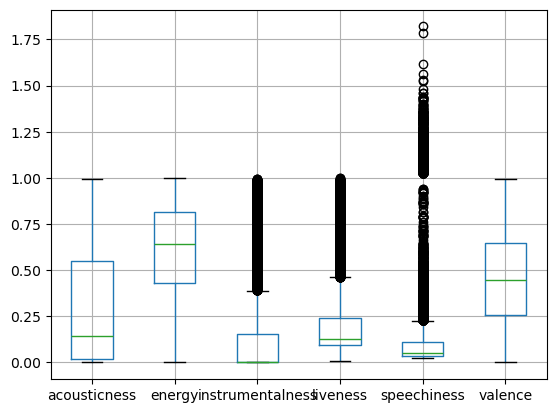

In [44]:
data_train.boxplot(['acousticness', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'])

Значения по эти признакам должны быть в диапазоне от 0 до 1.
Есть выбросы в speechiness. Удалим их.

In [45]:
data_train = data_train.query('0 < speechiness < 1')

In [46]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33489 entries, 1 to 39999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       33489 non-null  int64  
 1   track_name        33489 non-null  object 
 2   popularity        33489 non-null  float64
 3   acousticness      33489 non-null  float64
 4   danceability      33489 non-null  float64
 5   duration_ms       33489 non-null  float64
 6   energy            33489 non-null  float64
 7   instrumentalness  33489 non-null  float64
 8   key               32299 non-null  object 
 9   liveness          33489 non-null  float64
 10  loudness          33489 non-null  float64
 11  mode              31944 non-null  object 
 12  speechiness       33489 non-null  float64
 13  tempo             33489 non-null  float64
 14  valence           33489 non-null  float64
 15  music_genre       33489 non-null  object 
dtypes: float64(11), int64(1), object(4)
memory us

In [47]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        10000 non-null  object 
 2   popularity        10000 non-null  float64
 3   acousticness      10000 non-null  float64
 4   danceability      10000 non-null  float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9673 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9518 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  float64
 14  valence           10000 non-null  float64
dtypes: float64(11), int64(1), object(3)
memory usage: 1.1+ MB


**Промежуточный вывод**

- Рассмотрены даты загрузки. Они были сделаны с 1 по 4 апреля. Эти данные не имеют статистической значимости, удалены из датасета.

- Изучены пропуски в категориальных значениях
  - track_name:
 
   Приведены все названия в единый вид. Переведены в строчный регистр, убраны артикли и удалены лишние пробелы.
  
  - key

    Все корректно, 7 нот и 5 полутонов.

     Больше всего треков в тональностях Соль и До. Меньше всего в Ре-Диез.
    
  - mode
   
    Здесь тоже все корректно 2 вида модальности и пропуски.

    Треков в мажорной тональности почти в 2 раза больше.

  - music genre
 
    В наших данных для обучения содержится информация о 40000 треках. Это композиции в 10 жанрах. Данные распределены примерно одинаково, около 10% на каждый жанр.
    
- изучены пропуски и выбросы в количественных значениях

  - dancebility
 
    Есть выбросы. Композиции с танцевальностью меньше 0.1.

     Судя по названию, большинство таких композиций это классическая музыка и концерты. В таком случае, это информативная история. От таких выбросов избавляться не будем. 

    Пропуски заполнены медианным значением.
    
  - popularity
 
    Есть выбросы. Треки с популярностью больше 85 и меньше 0. Рассмотрим внимательнее.

    Популярные Рэп, Рок, Хип-Хоп и электро композиции, оставляем. Менее популярные это классика.

    Оставляем все объекты.

    Пропуски заполняем медианным значением.
    
  - tempo
 
    Найдена ошибка.

    Данные переведены в нужный формат.

    Пропуски заполнены медианным значением.

  - duration
 
    Выявлены отрицательные значения. Не понятен характе ошибок. Данные объекты удалены.
    Так же имееются выбросы, экстрадолгие композиции. судя по названиям это концерты симфонических оркестров.

  - loudness
 
    Удалены выбросы.

  - acousticness, energy, instrumentalness, liveness, speechiness, valence
 
    По условию данные признаки должны быть в пределах от 0 до 1.00.

    Выбросы удалены.
  Проверка на дубликаты 

   После удаление столбца с уникальным номером трека дубликаты не выявлены.
   

## 3. Проверка на дубликаты

In [48]:
#Удалить первую строку
#data_phik = data_train.set_index('instance_id')
data_train = data_train.drop('instance_id', axis=1)


In [49]:
print(data_train.duplicated().sum())


0


***Промежуточный вывод***


После удаление столбца с уникальным номером трека дубликаты не выявлены.
   

## 4. Кoрреляция признаков

In [50]:
data_train = data_train.drop('track_name', axis=1)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33489 entries, 1 to 39999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        33489 non-null  float64
 1   acousticness      33489 non-null  float64
 2   danceability      33489 non-null  float64
 3   duration_ms       33489 non-null  float64
 4   energy            33489 non-null  float64
 5   instrumentalness  33489 non-null  float64
 6   key               32299 non-null  object 
 7   liveness          33489 non-null  float64
 8   loudness          33489 non-null  float64
 9   mode              31944 non-null  object 
 10  speechiness       33489 non-null  float64
 11  tempo             33489 non-null  float64
 12  valence           33489 non-null  float64
 13  music_genre       33489 non-null  object 
dtypes: float64(11), object(3)
memory usage: 3.8+ MB


In [51]:
phik_overview = data_train.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
popularity,1.00,0.36,0.35,0.10,0.38,0.37,0.07,0.10,0.38,0.03,0.26,0.12,0.21,0.77
acousticness,0.36,1.00,0.48,0.14,0.77,0.48,0.10,0.20,0.72,0.03,0.24,0.33,0.43,0.67
danceability,0.35,0.48,1.00,0.16,0.54,0.36,0.10,0.12,0.50,0.10,0.34,0.37,0.56,0.63
duration_ms,0.10,0.14,0.16,1.00,0.15,0.16,0.02,0.06,0.17,0.01,0.05,0.04,0.14,0.19
energy,0.38,0.77,0.54,0.15,1.00,0.47,0.10,0.27,0.84,0.05,0.26,0.37,0.51,0.68
instrumentalness,0.37,0.48,0.36,0.16,0.47,1.00,0.05,0.15,0.52,0.09,0.22,0.22,0.38,0.58
key,0.07,0.10,0.10,0.02,0.10,0.05,1.00,0.05,0.09,0.35,0.12,0.04,0.05,0.17
liveness,0.10,0.20,0.12,0.06,0.27,0.15,0.05,1.00,0.21,0.02,0.16,0.09,0.15,0.21
loudness,0.38,0.72,0.50,0.17,0.84,0.52,0.09,0.21,1.00,0.03,0.24,0.34,0.47,0.69
mode,0.03,0.03,0.10,0.01,0.05,0.09,0.35,0.02,0.03,1.00,0.10,0.03,0.04,0.29


In [52]:
interval_cols = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
phik_overview = data_train.phik_matrix(interval_cols=interval_cols)

/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


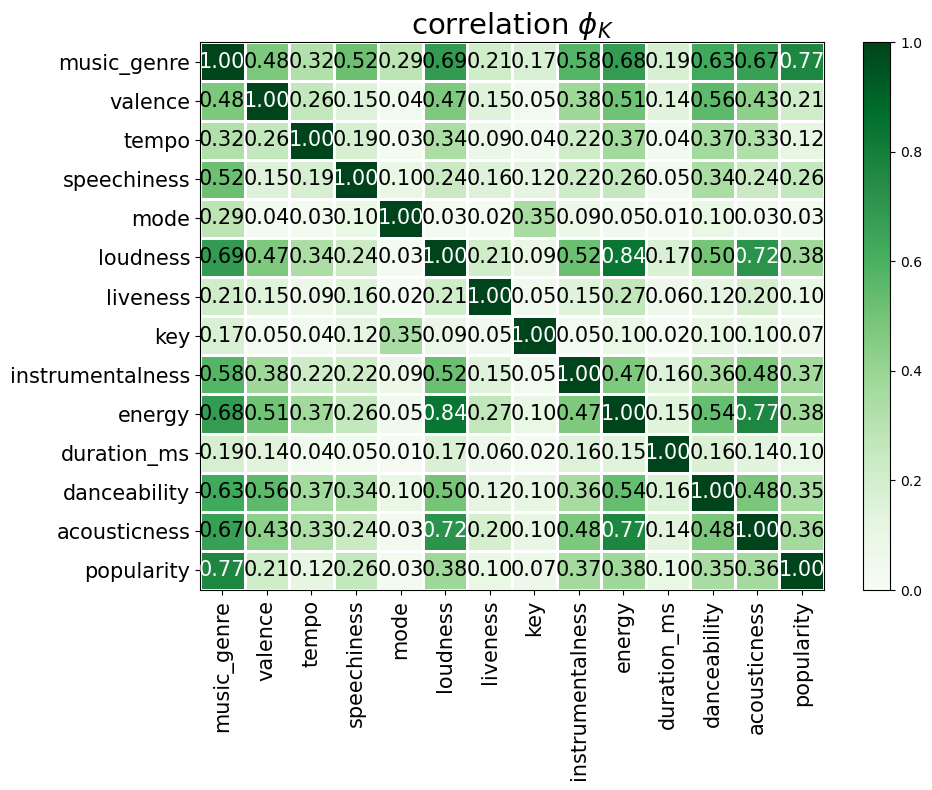

In [53]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))

plt.show()

energy сильно коррелирует с loudness и acousticness.
Пока удалять не будем

/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/phik/significance.py:328: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


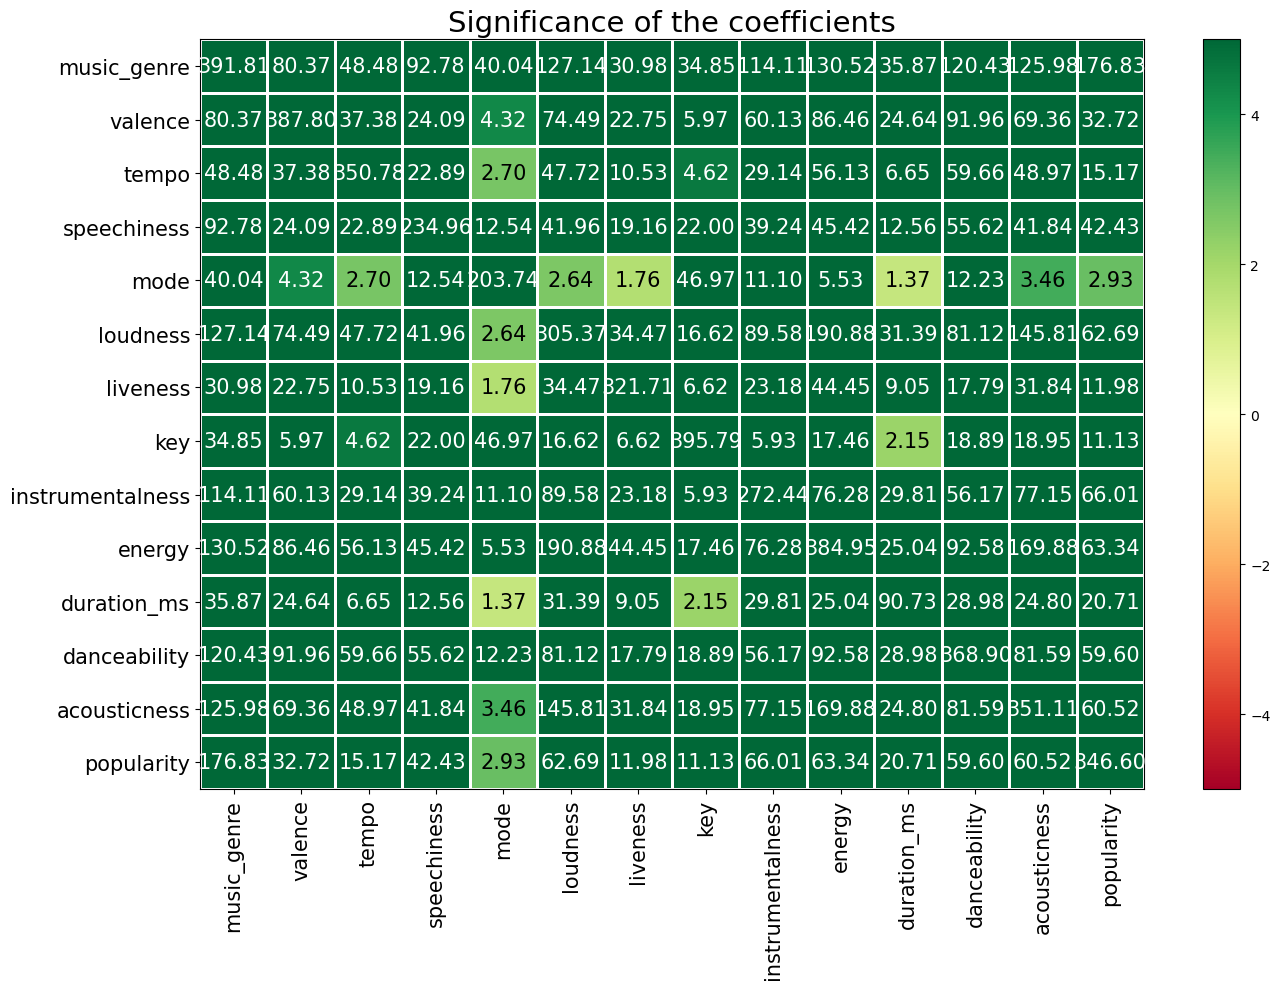

In [54]:
significance_overview = data_train.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(14, 10))
plt.show()

***Промежуточный вывод***

Выявлена корреляция energy с loudness и acousticness.
Удалять не будем

## 5. Создание модели

In [55]:
#Выделяем целевой признак
X = data_train.drop(columns='music_genre')
y = data_train.music_genre

X.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
1,55.0,0.0647,0.282,288333.0,0.7380,0.014200,C,0.290,-5.566,Major,0.0324,126.914,0.2110
2,39.0,0.9310,0.364,115240.0,0.3490,0.940000,NaN,0.110,-13.279,NaN,0.0321,65.427,0.0891
3,56.0,0.0123,0.332,234638.0,0.8470,0.000027,B,0.297,-4.513,Minor,0.0910,67.230,0.3920
4,52.0,0.5800,0.716,221640.0,0.6140,0.000014,G,0.160,-7.099,Major,0.0360,88.006,0.6800
5,45.0,0.9940,0.299,267533.0,0.0319,0.928000,D,0.105,-30.624,Major,0.0603,105.922,0.0975


In [56]:
#Делим обучающую выборку на непосредственно обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=state)

In [57]:
#Делим признаки на катгориальный и количественные
cat_columns = X.select_dtypes(include='object').columns.tolist()
num_columns = X.select_dtypes(include='float64').columns.tolist()
cat_columns

['key', 'mode']

### 5.1 Дерево решений

In [58]:
#Инициируем модель  
model = DecisionTreeClassifier(random_state=state)

In [59]:
#Прописываем column_transformer для обработки каждого типа данных
column_transformer = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')  

#Создаем pipeline в который будут входить и преобразователь и модель 
pipeline = make_pipeline(column_transformer, model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x17E468540))])

In [60]:
params = {
          'columntransformer__standardscaler': [StandardScaler(), MinMaxScaler()],
          'decisiontreeclassifier__max_depth':(1, 20, 2),
          'decisiontreeclassifier__min_samples_leaf': (2, 10, 1)
         }

In [61]:
gs = GridSearchCV(pipeline, params, cv=5)

In [62]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['popularity',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x17E468540))]),
             param_grid={'columntransformer__standardscaler': [StandardScaler(),
                                                               MinMaxScaler()],
                         'decisiontreeclassifier__max_depth': (1, 20, 2),
                         'decisiontreeclassifier__min_samples_leaf': (2, 10,
                                                                      1)})

In [63]:
gs.best_params_

{'columntransformer__standardscaler': StandardScaler(),
 'decisiontreeclassifier__max_depth': 20,
 'decisiontreeclassifier__min_samples_leaf': 10}

In [64]:
gs.best_score_

0.4728853721923737

In [65]:
preds = gs.predict(X_valid)
print('f1_micro лучшей модели дерева решений:', f1_score(y_valid, preds, average='micro').round(2))

f1_micro лучшей модели дерева решений: 0.47


### 5.2 Лес деревьев

In [66]:
model = RandomForestClassifier(random_state=state)
pipeline = make_pipeline(column_transformer, model)
pipeline.fit(X_train, y_train)
params = {
          'columntransformer__standardscaler': [StandardScaler(), MinMaxScaler()],
          'randomforestclassifier__n_estimators':(5, 35, 3),
          'randomforestclassifier__max_depth':(3, 15, 2),
          'randomforestclassifier__min_samples_leaf': (2, 5, 1)
         }

In [67]:
gs = GridSearchCV(pipeline, params, cv=5)

In [68]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['popularity',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=RandomState(MT19937) at 0x17E468540))]),
             param_grid={'columntransformer__standardscaler': [StandardScaler(),
                                                               MinMaxScaler()],
                         'randomforestclassifier__max_depth': (3, 15, 2),
                         'randomforestclassifier__min_samples_leaf': (2, 5, 1),
                         'randomforestclassifier__n_estimators': (5, 35, 3)})

In [69]:
gs.best_score_

0.5480569158938945

In [70]:
gs.best_params_

{'columntransformer__standardscaler': StandardScaler(),
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 35}

In [71]:
preds = gs.predict(X_valid)
print('f1_micro лучшей леса деревьев:', f1_score(y_valid, preds, average='micro').round(2))

f1_micro лучшей леса деревьев: 0.55


### 5.3 Логистическая регрессия

In [72]:
model = LogisticRegression(random_state=state)
pipeline = make_pipeline(column_transformer, model)
pipeline.fit(X_train, y_train)
params = {
          'columntransformer__standardscaler': [StandardScaler(), MinMaxScaler()],
          'logisticregression__solver':['bfgs', 'sag', 'saga'],
          'logisticregression__max_iter' : (100, 500, 100)
}

In [73]:
gs = GridSearchCV(pipeline, params, cv=5)

In [74]:
gs.fit(X_train, y_train)

/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['popularity',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=RandomState(MT19937) at 0x17E468540))]),
             param_grid={'columntransformer__standardscaler': [StandardScaler(),
                                                               MinMaxScaler()],
                         'logisticregression__max_iter': (100, 500, 100),
                         'logisticregression__solver': ['bfgs', 'sag', 'saga']})

In [75]:
gs.best_score_

0.5100729320285919

In [76]:
gs.best_params_

{'columntransformer__standardscaler': StandardScaler(),
 'logisticregression__max_iter': 100,
 'logisticregression__solver': 'saga'}

In [77]:
preds = gs.predict(X_valid)
print('f1_micro лучшей логистической регрессии:', f1_score(y_valid, preds, average='micro').round(2))

f1_micro лучшей логистической регрессии: 0.51


***Промежуточный вывод***

- f1_micro лучшей модели дерева решений: 0.47

- f1_micro лучшей модели леса деревьев: 0.55

- f1_micro лучшей логистической регрессии: 0.51

  Для предсказания значений на тестовой выборке мы используем модель Леса дереьвев с параметрами:

 'columntransformer__standardscaler': StandardScaler(),
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 35

## 6. Предсказание значений на тестовой выборке

In [78]:
column_transformer = make_column_transformer((MinMaxScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')  
model = RandomForestClassifier(random_state=state, max_depth = 15, min_samples_leaf = 5, n_estimators = 35)
pipeline = make_pipeline(column_transformer, model)
pipeline.fit(X_train, y_train)
preds = pipeline.predict(data_test)
p = pd.DataFrame(data=preds)

In [79]:
p = p.rename(columns = {0: 'music_genre'})

In [80]:
predictions_final = pd.concat([data_test,p], axis=1)
predictions_final = predictions_final[['instance_id', 'music_genre']]
predictions_final.head()

,instance_id,music_genre
0,20514,Jazz
1,46957,Hip-Hop
2,5488,Electronic
3,18150,Alternative
4,20148,Alternative


In [81]:
predictions_final.to_csv('/Users/mariaspartalan/Desktop/готовые проекты/9 мифасоль/predictions_final.csv', index=False)

### ОБЩИЙ ВЫВОД: ###

Данные выгружены успешно. 
40000 объектов в обучающей выборке и 10000 в тестовой.

- Рассмотрены даты загрузки. Они были сделаны с 1 по 4 апреля. Эти данные не имеют статистической значимости, удалены из датасета.

- Изучены пропуски в категориальных значениях
  - track_name:
 
   Приведены все названия в единый вид. Переведены в строчный регистр, убраны артикли и удалены лишние пробелы.
  
  - key

    Все корректно, 7 нот и 5 полутонов.

     Больше всего треков в тональностях Соль и До. Меньше всего в Ре-Диез.
    
  - mode
   
    Здесь тоже все корректно 2 вида модальности и пропуски.

    Треков в мажорной тональности почти в 2 раза больше.

  - music genre
 
    В наших данных для обучения содержится информация о 40000 треках. Это композиции в 10 жанрах. Данные распределены примерно одинаково, около 10% на каждый жанр.
    
- изучены пропуски и выбросы в количественных значениях

  - dancebility
 
    Есть выбросы. Композиции с танцевальностью меньше 0.1.

     Судя по названию, большинство таких композиций это классическая музыка и концерты. В таком случае, это информативная история. От таких выбросов избавляться не будем. 

    Пропуски заполнены медианным значением.
    
  - popularity
 
    Есть выбросы. Треки с популярностью больше 85 и меньше 0. Рассмотрим внимательнее.

    Популярные Рэп, Рок, Хип-Хоп и электро композиции, оставляем. Менее популярные это классика.

    Оставляем все объекты.

    Пропуски заполняем медианным значением.
    
  - tempo
 
    Найдена ошибка.

    Данные переведены в нужный формат.

    Пропуски заполнены медианным значением.

  - duration
 
    Выявлены отрицательные значения. Не понятен характе ошибок. Данные объекты удалены.
    Так же имееются выбросы, экстрадолгие композиции. судя по названиям это концерты симфонических оркестров.

  - loudness
 
    Удалены выбросы.

  - acousticness, energy, instrumentalness, liveness, speechiness, valence
 
    По условию данные признаки должны быть в пределах от 0 до 1.00.

    Выбросы удалены.
  Проверка на дубликаты 

   После удаление столбца с уникальным номером трека дубликаты не выявлены.


   Выявлена корреляция energy с loudness и acousticness.
Удалять не будем

   Создан пайплайн, который анализирует признаки. Разделяет их по типу, кличественный масштабирует и категориальные кодирует. Далее на обработнных данных были обучены различные модели. Для каждой были подобраны оптимальные параметры. Проведена проверка качества работы с каждой по признаку f1_micro.

  - f1_micro лучшей модели дерева решений: 0.47

  - f1_micro лучшей модели леса деревьев: 0.55

  - f1_micro лучшей логистической регрессии: 0.51

  Для предсказания значений на тестовой выборке мы используем модель Леса дереьвев с параметрами:

 'columntransformer__standardscaler': StandardScaler(),
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 35

______________________________________

Данная модель обработала тестовую выборку и предсказала жанры для треков. Данные предсказания сохранены в таблице predictions_final.